# Experiment Name: Control

Lee et al. (2023), but with 1940-2023 climatology and polynomial detrending.

In [1]:
# import packages
import numpy as np
import pandas as pd
import xarray as xr
import glob
from matplotlib import pyplot as plt
from numpy.polynomial import polynomial
from sklearn.linear_model import LinearRegression
import copy

# Steps 2-6: Compute anomalies

In [2]:
path_origins = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'

# 2. Extract domain

In [3]:
name_reanalysis = 'ERA5'
dataset_raw = xr.open_dataset(
    f'{path_origins}Z500_{name_reanalysis}.nc'
)
lat0=20; lat1=80; lon0=180; lon1=330
dataset_region = dataset_raw.where(
    (
        dataset_raw.lat>=lat0)&(
            dataset_raw.lat<=lat1)&(
            dataset_raw.lon>=lon0)&(
            dataset_raw.lon<=lon1),
    drop=True
)

In [4]:
# Divide by gravity to convert from m2/s2 to m
dataset_region.Z.data = dataset_region.Z.data / 9.82

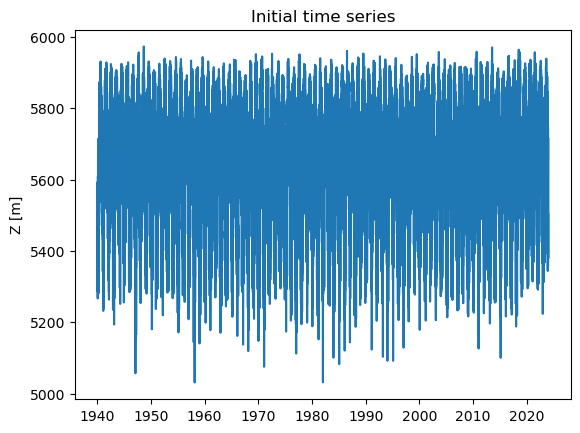

In [5]:
# plots example time series for a grid cell
example_time_series = dataset_region.Z.sel(
    lat=39, lon=-77 + 360
)
plt.plot(
    example_time_series.time, 
    example_time_series
)
plt.title('Initial time series')
plt.ylabel('Z [m]')
plt.show()

## 3. Compute anomalies

In [6]:
def doy_helper(ds):

    # Remove leap day (Feb 29)
    ds = ds.isel(
        time=~((pd.to_datetime(ds.time).day == 29)&(pd.to_datetime(ds.time).month == 2))
    )
    
    # Create day of year (DOY) array for indexing
    doy = np.tile(
        np.arange(1, 366, 1, dtype='int32'),
        len(pd.to_datetime(ds.time).year.unique())
    )

    # rework dims/coords for climo
    return ds.rename({'time':'doy'}).assign_coords({'doy':('doy', doy)})

def return_from_doy_helper(dswdoy, dswtime):

    # Remove leap day (Feb 29)
    dswtime = dswtime.isel(
        time=~((pd.to_datetime(dswtime.time).day == 29)&(pd.to_datetime(dswtime.time).month == 2))
    )

    # save time coord
    time_arr = pd.to_datetime(dswtime.time.values)

    # reverse to time instead of doy
    return dswdoy.assign_coords({'doy':('doy', time_arr)}).rename({'doy':'time'})

def get_climatology_smoothed(ds, var, window=60, fileauthor='Jhayron S. Pérez-Carrasquilla'):
    
    # rename ds object
    ds_clima = ds

    # adjust to doy coords/dims
    ds_clima = doy_helper(ds_clima)
    
    # Compute the daily mean for each day of the year
    climo = []
    for i in range(1, 366):
        daily_mean = ds_clima.sel(doy=i)[var].mean('doy')
        climo.append(daily_mean)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = ds[var].attrs
    attrs['File Author'] = fileauthor
    
    climo = xr.Dataset({
        f'{var}_climo': (['doy', 'lat', 'lon'], np.array(climo)),
    }, 
    coords={
        'doy': np.arange(1, 366, 1),
        'lat': ds.lat.values,
        'lon': ds.lon.values,
    },
    attrs=attrs
    )

    # reorder dims
    climo = climo.transpose('doy', 'lat', 'lon')

    # sanity check
    print(climo[f'{var}_climo'].shape)
    
    # Stack climatology 3 times to handle edges
    climo_extended = xr.concat([climo, climo, climo], dim='doy')

    # Adjust coordinates after stacking to represent a larger time span
    climo_extended['doy'] = np.arange(1, 365 * 3 + 1, 1)

    # Apply rolling mean with a 60-day window for smoothing
    climo_smoothed = climo_extended.rolling(doy=window, center=True, min_periods=1).mean(skipna=True)

    # Extract the middle portion, corresponding to the original 365 days
    climo_smoothed = climo_smoothed.isel(doy=slice(365, 365 + 365))

    # sanity check
    print(climo_smoothed[f'{var}_climo'].shape)
    
    # Reset 'day_of_year' coordinate to original range
    climo_smoothed['doy'] = np.arange(1, 366, 1)

    return climo_smoothed

def get_anomalies(ds, var, climo):

    # deep copy dataset
    anom = copy.deepcopy(ds)

    # adjust to doy coords/dims
    dstmp = doy_helper(ds)
    anom = doy_helper(anom)

    # compute doy anomalies
    for day in range(1, 366):
        anom[var][{'doy':(dstmp.doy == day)}] = (dstmp[var].sel(doy=day) - climo[f'{var}_climo'].sel(doy=day))

    # back to dataset
    anom = anom.rename({var:f'{var}_anom'})

    # add original time dim
    return return_from_doy_helper(anom, ds)

In [7]:
clima = get_climatology_smoothed(dataset_region, 'Z')

(365, 61, 151)
(365, 61, 151)


In [8]:
anoms = get_anomalies(dataset_region, 'Z', clima)

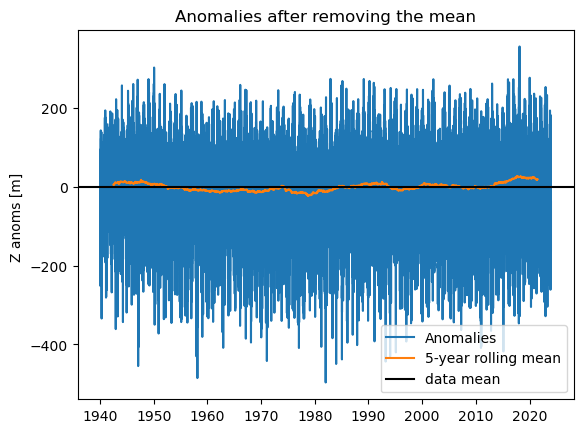

In [9]:
example_time_series = anoms.Z_anom.sel(
    lat=39,
    lon=-77 + 360
)
plt.plot(
    example_time_series.time,
    example_time_series,
    label='Anomalies'
)
plt.plot(
    example_time_series.time,
    example_time_series.rolling(time=5*365,center=True).mean(),
    label = '5-year rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='data mean'
)
plt.title('Anomalies after removing the mean')
plt.ylabel('Z anoms [m] ')
plt.legend()
plt.show()

## 4. Apply Fourier low-pass filter

In [10]:
def fourierfilter(da, cutoff_period=10):
    
    # Compute the Fourier transform along the time axis
    fft_data = np.fft.fft(da, axis=0)
    
    # Get the frequencies corresponding to the FFT components
    freqs = np.fft.fftfreq(da.shape[0], d=1)
    # d=1 assumes daily data; adjust if different
    
    # Compute the corresponding periods (in days)
    periods = np.abs(1 / freqs)
    
    # Define the cutoff period for low-pass filter (10 days)
    cutoff_period = cutoff_period
    
    # Create a mask to filter out high-frequency components (shorter than 10 days)
    high_pass_mask = periods < cutoff_period
    
    # Apply the mask to the FFT data (set high-frequency components to zero)
    fft_data_filtered = fft_data.copy()
    fft_data_filtered[high_pass_mask, :, :] = 0
    
    # Perform the inverse FFT to get the filtered data back in the time domain
    filtered_data = np.fft.ifft(fft_data_filtered, axis=0).real
    
    # Create a new xarray DataArray to store the filtered data
    filtered_anom = xr.DataArray(
        filtered_data,
        dims=da.dims,
        coords=da.coords,
        attrs=da.attrs
    )
    return filtered_anom

In [11]:
anoms_filtered = fourierfilter(anoms.Z_anom)
anoms_filtered = anoms_filtered.to_dataset(name='Z_anom')

/glade/derecho/scratch/molina/tmp/ipykernel_63214/2965568547.py:11: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


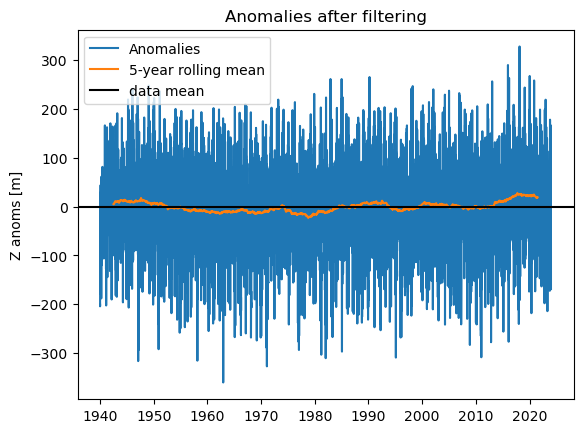

In [12]:
example_time_series = anoms_filtered.Z_anom.sel(
    lat=39, 
    lon=-77 + 360
)
plt.plot(
    example_time_series.time, 
    example_time_series, 
    label='Anomalies'
)
plt.plot(
    example_time_series.time, 
    example_time_series.rolling(time=5 * 365, center=True).mean(skipna=True), 
    label='5-year rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='data mean'
)
plt.title('Anomalies after filtering')
plt.ylabel('Z anoms [m]')
plt.legend()
plt.show()

## 5. Remove trends of the region (the trend of each DOY)

In [13]:
# Build a time series with the polynomials for each DOY
# the smoothed data I use for trends
anoms_smooth = copy.deepcopy(anoms_filtered).rolling(
    time=60, center=True, min_periods=1
).mean(skipna=True)

In [14]:
# Get average time series of the region
def get_weighted_area_average(da):
    
    # Compute the cosine of the latitudes (in radians) for weighting
    # For a rectangular grid the cosine of the latitude is proportional to the grid cell area
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"

    # Apply the weights and compute the mean across lat/lon
    da_weighted = da.weighted(weights)
    weighted_mean = da_weighted.mean(dim=['lat', 'lon'])
    
    return weighted_mean

In [15]:
mean_series = get_weighted_area_average(anoms_smooth.Z_anom)

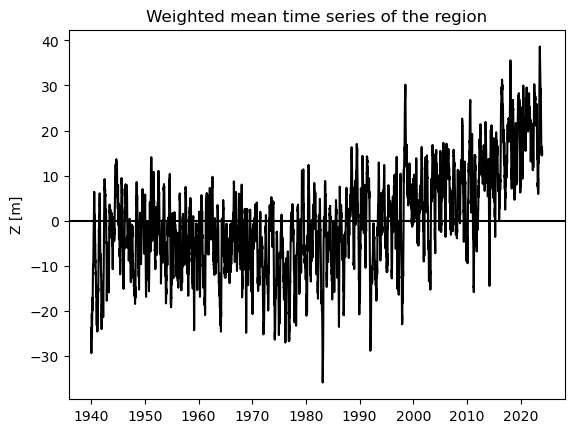

In [16]:
plt.plot(
    mean_series.time,
    mean_series,
    color='k'
)
plt.axhline(
    np.mean(mean_series),
    color='k'
)
plt.title('Weighted mean time series of the region')
plt.ylabel('Z [m]')
plt.show()

In [17]:
def create_doy_dummy(num_yr=84):
    """Creates dummy array for indexing the non-leap year based doy time series"""
    days_per_year = 365
    years = num_yr
    day_indices = np.arange(
        0, 
        years * days_per_year, 
        days_per_year,
        dtype=int
    ).reshape(-1, 1) + np.arange(days_per_year)
    return day_indices

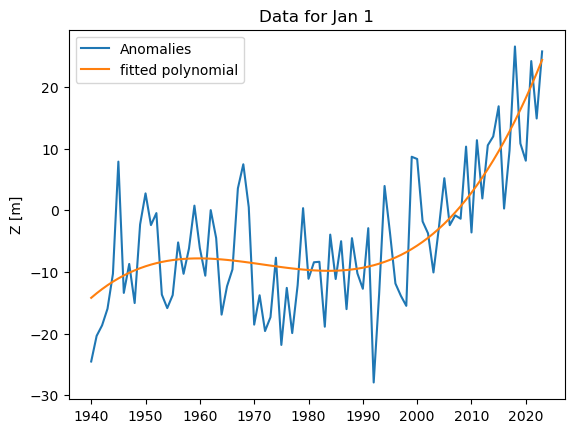

In [18]:
full_curve = copy.deepcopy(mean_series)
full_curve.data = np.zeros(len(full_curve))
npoly=3
doy_tmp = create_doy_dummy()

# Iterate through every day of the year
for i in range(0, 365): 
    
    doy_indx = doy_tmp[:, i]
    
    # fit a polynomial for the trend of each DOY
    params_curve = polynomial.polyfit(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        mean_series[doy_indx], 
        npoly
    )
    curve = polynomial.polyval(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        params_curve, 
        tensor=True
    )
    
    # Center curve in zero
    full_curve.loc[{'time': mean_series[doy_indx].time}] = curve

    # plot first doy
    if i==0:
        plt.plot(
            mean_series[doy_indx].time,
            mean_series[doy_indx],
            label='Anomalies'
        )
        plt.plot(
            mean_series[doy_indx].time,
            curve,
            label='fitted polynomial'
        )
        plt.title('Data for Jan 1')
        plt.ylabel('Z [m]')
        plt.legend()
        plt.show()

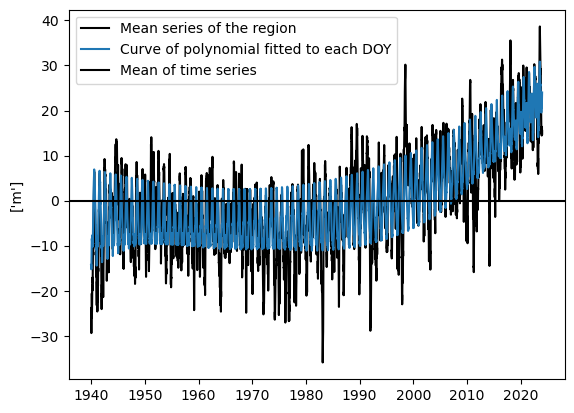

In [19]:
plt.plot(
    mean_series.time,
    mean_series,
    color='k',
    label='Mean series of the region'
)
plt.plot(
    full_curve.time,
    full_curve,
    label='Curve of polynomial fitted to each DOY'
)
plt.axhline(
    np.mean(mean_series),
    color='k',
    label='Mean of time series'
)
plt.ylabel(['m'])
plt.legend()
plt.show()

In [20]:
# Remove curve from data
anoms_detrended = anoms_filtered.Z_anom - full_curve.data[:, np.newaxis, np.newaxis]

In [21]:
anoms_detrended = anoms_detrended.to_dataset(name='Z_anom')

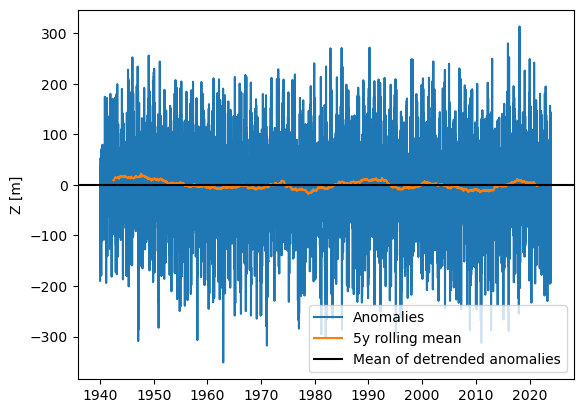

In [22]:
example_time_series = anoms_detrended.Z_anom.sel(
    lat=39, 
    lon=-77 + 360
)
plt.plot(
    example_time_series.time,
    example_time_series,
    label='Anomalies'
)
plt.plot(
    example_time_series.time,
    example_time_series.rolling(time=5 * 365,center=True).mean(skipna=True),
    label='5y rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='Mean of detrended anomalies'
)
plt.legend()
plt.ylabel('Z [m]')
plt.show()

## 6. Standardize anomalies

In [23]:
def get_climatology_std_smoothed(ds, var, window=60, fileauthor='Jhayron S. Pérez-Carrasquilla'):

    # Get the day of year (DOY)
    doy_tmp = create_doy_dummy()
    
    # Compute the daily standard deviation for each day of the year
    climo = []
    for i in range(0, 365):
        # grab indices for doy
        doy_indx = doy_tmp[:, i]
        
        # ensure time is first axis with transpose
        array_temp = ds[var].transpose('time', 'lat', 'lon')[doy_indx]

        # compute std for doy
        std = np.nanstd(array_temp, axis=0)
        # make nan where 0
        std[std == 0] = np.nan
        climo.append(std)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = ds[var].attrs
    attrs['File Author'] = fileauthor
    
    climo = xr.Dataset({
        f'{var}_climo_std': (['doy', 'lat', 'lon'], np.array(climo)),
    }, 
    coords={
        'doy': np.arange(1, 366, 1),
        'lat': ds.lat.values,
        'lon': ds.lon.values,
    },
    attrs=attrs)

    climo = climo.transpose('doy', 'lat', 'lon')
    
    # Stack climatology 3 times to handle edges
    climo_extended = xr.concat([climo, climo, climo], dim='doy')

    # Adjust coordinates after stacking to represent a larger time span
    climo_extended['doy'] = np.arange(1, 365 * 3 + 1, 1)

    # Apply rolling mean with a 60-day window for smoothing
    climo_smoothed = climo_extended.rolling(doy=window, center=True, min_periods=1).mean(skipna=True)

    # Extract the middle portion, corresponding to the original 365 days
    climo_smoothed = climo_smoothed.isel(doy=slice(365, 365 + 365))

    # Reset 'day_of_year' coordinate to original range
    climo_smoothed['doy'] = np.arange(1, 366, 1)

    return climo_smoothed

# this func is not used (below)
def standardize_anomalies(anom, var, climo_std):

    # ensure time is first dim/axis
    anom = anom.transpose('time', 'lat', 'lon')
    std_anom = copy.deepcopy(anom)
    
    # Get the day of year (DOY)
    doy_tmp = create_doy_dummy()

    for i in range(0, 365):
        
        doy_indx = doy_tmp[:, i]

        std_anom[var][doy_indx] = (
            anom[var][doy_indx] / climo_std[f'{var}_climo_std'].sel(doy=i + 1)
        )
    return std_anom

In [24]:
clima_std = get_climatology_std_smoothed(
    anoms_detrended, 
    'Z_anom'
)

In [25]:
clima_std_average_region_series = get_weighted_area_average(
    clima_std
)

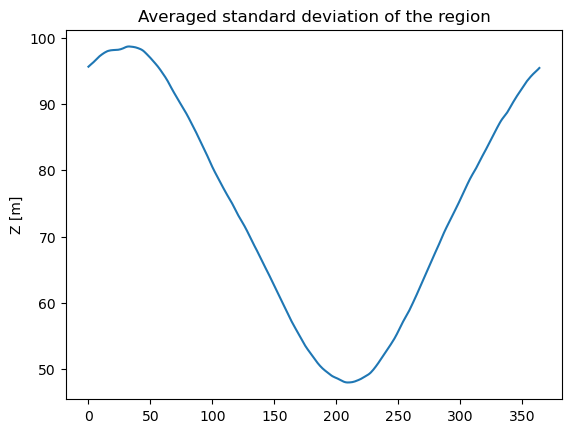

In [26]:
plt.plot(
    clima_std_average_region_series.Z_anom_climo_std
)
plt.title('Averaged standard deviation of the region')
plt.ylabel('Z [m]')
plt.show()

In [27]:
anoms_standardized = copy.deepcopy(anoms_detrended).Z_anom
anoms_standardized.data = np.zeros_like(anoms_standardized.data)
doy_tmp = create_doy_dummy()

for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]

    # grab doy std (climo)
    std_temp = clima_std_average_region_series.Z_anom_climo_std[i].data
    
    # standardize the detrended anoms by std climo
    standardized_temp = anoms_detrended.Z_anom[doy_indx].data / std_temp
    
    anoms_standardized.loc[{'time': anoms_detrended.Z_anom[doy_indx].time}] = standardized_temp

In [28]:
anoms_standardized = anoms_standardized.to_dataset(name='Z_anom')

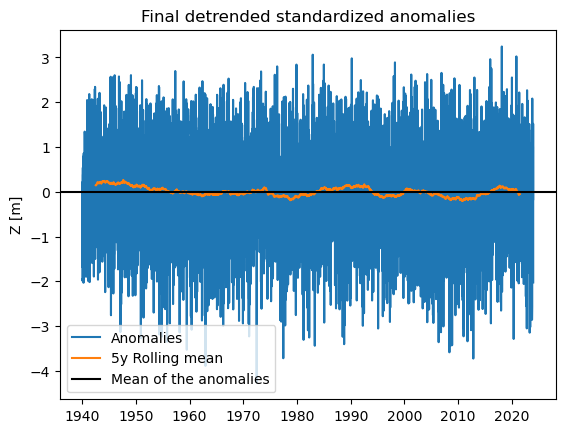

In [29]:
example_time_series = anoms_standardized.Z_anom.sel(
    lat=39, 
    lon=-77 + 360
)
plt.plot(
    example_time_series.time,
    example_time_series,
    label='Anomalies'
)
plt.plot(
    example_time_series.time,
    example_time_series.rolling(time=5 * 365, center=True).mean(skipna=True),
    label='5y Rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='Mean of the anomalies'
)
plt.legend()
plt.ylabel('Z [m]')
plt.title('Final detrended standardized anomalies')
plt.show()

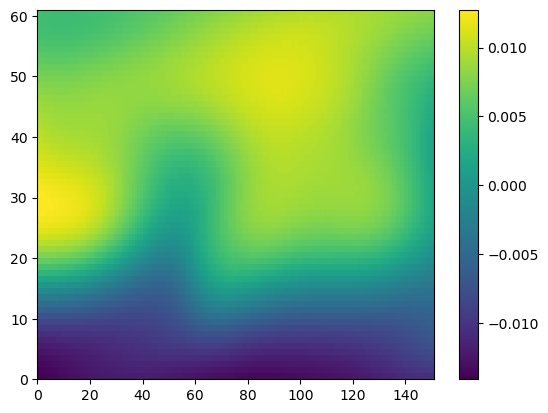

In [30]:
plt.pcolormesh(anoms_standardized.mean('time').Z_anom)
plt.colorbar()
plt.show()

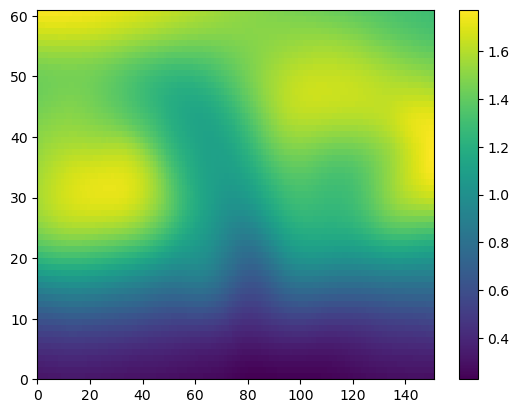

In [31]:
plt.pcolormesh(anoms_standardized.std('time').Z_anom)
plt.colorbar()
plt.show()

In [32]:
anoms_standardized.to_netcdf(
    '/glade/derecho/scratch/molina/Z_anom_ERA5_Clean.nc'
)

# 7-9 Compute PCs and WRs

In [33]:
import joblib
import pickle
import copy
import math
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely import geometry

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
# import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.metrics import accuracy_score

In [34]:
anoms_standardized = xr.open_dataset(
    '/glade/derecho/scratch/molina/Z_anom_ERA5_Clean.nc'
)

## 7. Compute PCs

In [35]:
var_name = 'Z_anom'
z500_anoms_flattened = anoms_standardized.stack(flat=('lat','lon')).transpose('time','flat')[var_name]

In [36]:
z500_anoms_flattened_training = copy.deepcopy(z500_anoms_flattened)

In [37]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(z500_anoms_flattened_training)

# transform era5 data with pca
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened_training)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}')

filename = r'/glade/derecho/scratch/molina/PCA_ERA5_v20250117_clean.mdl'
joblib.dump(pca_obj, filename)

filename = r'/glade/derecho/scratch/molina/PCA_ERA5_v20250117_clean.pkl'
pickle.dump(pca_obj, open(filename, 'wb'))

Variance explained: [18.97228522 14.01613688 10.17079212  7.41448908  6.62958318  5.79975552
  5.0390598   4.59610363  3.4734353   2.91119973  2.43460385  2.14035221]
Cumulative sum of variance explained for EOF1 and EOF2: [18.97228522 32.9884221  43.15921423 50.5737033  57.20328648 63.00304201
 68.0421018  72.63820544 76.11164074 79.02284047 81.45744432 83.59779653]


In [38]:
pca_obj = joblib.load(
    r'/glade/derecho/scratch/molina/PCA_ERA5_v20250117_clean.mdl'
)
z500_anoms_transformed = pca_obj.transform(
    z500_anoms_flattened_training
)

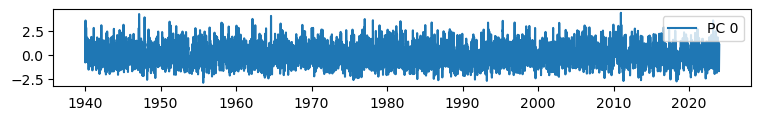

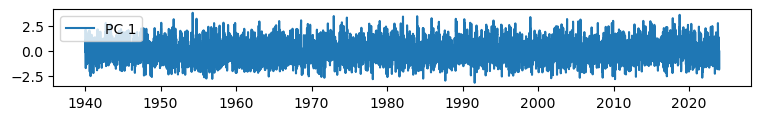

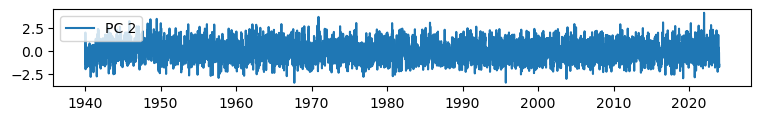

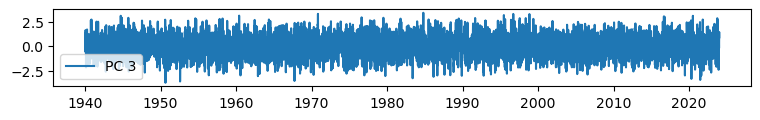

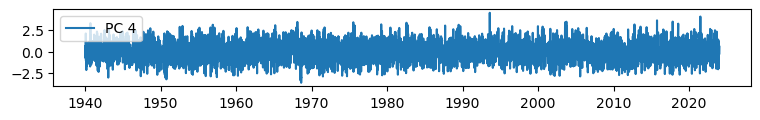

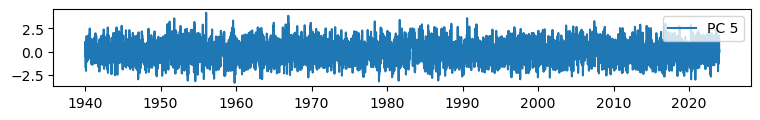

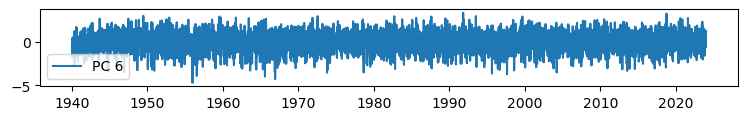

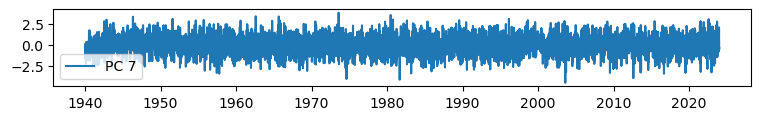

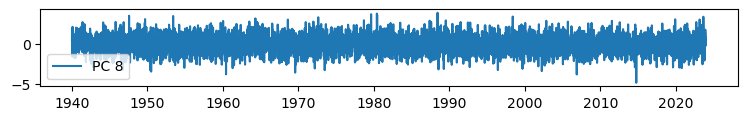

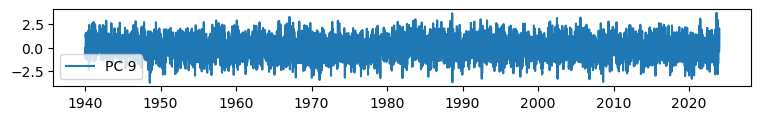

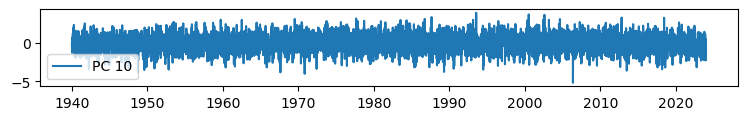

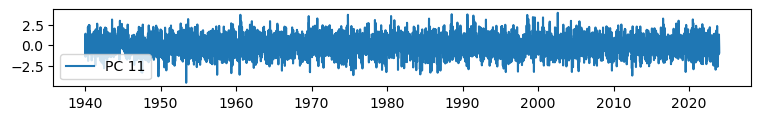

In [39]:
for i in range(12):
    plt.figure(figsize=(9,1))
    plt.plot(
        anoms_standardized.time,
        z500_anoms_transformed[:,i],
        label=f'PC {i}'
    )
    plt.legend()
    plt.show()
    plt.close()

## 8. Find optimal number of clusters

In [40]:
## function to run the kmeans algorithm with one specific seed
def run_kmeans(params_temp):
    data, seed, k, n_init_internal = params_temp
    kmeans = KMeans(
        n_clusters=k, 
        init='k-means++', 
        n_init=n_init_internal, 
        random_state=seed
    )
    kmeans.fit(data)
    return {
        "inertia": kmeans.inertia_,
        "cluster_centers": kmeans.cluster_centers_,
        "labels": kmeans.labels_
    }

In [41]:
data4clustering = copy.deepcopy(z500_anoms_transformed)
random_seed = 0
n_init = 500

In [42]:
dic_results_best_k = {}
dic_results_best_k['db_index'] = []
dic_results_best_k['max_intercluster_corr'] = []
dic_results_best_k['centroids'] = []
dic_results_best_k['labels'] = []
dbis = []
for k in range(2, 11):
    print(k)
    results_kmeans = run_kmeans((
        data4clustering,
        random_seed,
        k,
        n_init
    ))
    ## Compute the Davies-Bouldin Score 
    dbi = davies_bouldin_score(
        data4clustering, 
        results_kmeans['labels']
    )
    ## Compute the maximum intercluster correlation
    correlation_matrix = np.corrcoef(results_kmeans['cluster_centers'])
    np.fill_diagonal(correlation_matrix, np.nan) # operates without object assignment
    max_intercluster_corr = np.nanmax(correlation_matrix)
    
    dic_results_best_k['db_index'].append(dbi)
    dic_results_best_k['max_intercluster_corr'].append(max_intercluster_corr)
    dic_results_best_k['centroids'].append(results_kmeans['cluster_centers'])
    dic_results_best_k['labels'].append(results_kmeans['labels'])

2
3
4
5
6
7
8
9
10


In [43]:
np.save(
    'dic_results_best_k_ERA5_clean.npy', 
    dic_results_best_k
)

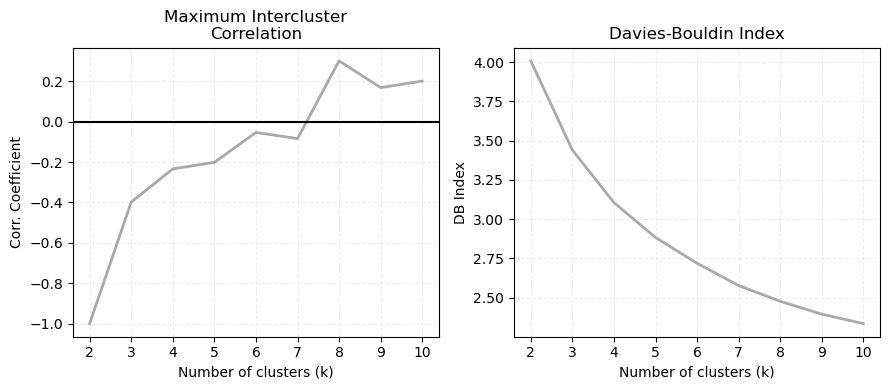

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))

axes[0].plot(
    np.arange(2,11),
    dic_results_best_k['max_intercluster_corr'],
    color='darkgray',
    lw=2
)
axes[0].axhline(0,color='k')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Corr. Coefficient')
axes[0].set_title('Maximum Intercluster\nCorrelation')
axes[0].set_xticks(np.arange(2,11))
axes[0].grid(alpha=0.2,ls='--')

axes[1].plot(
    np.arange(2,11),
    dic_results_best_k['db_index'],
    color='darkgray',
    lw=2
)
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_title('Davies-Bouldin Index')
axes[1].set_ylabel('DB Index')
axes[1].set_xticks(np.arange(2,11))
axes[1].grid(alpha=0.2,ls='--')

plt.tight_layout()
plt.show()
# plt.savefig(f'{path_figures}DBI.png',bbox_inches='tight')

## 9. Plot composites for best k

In [45]:
maxcorrs = np.array(copy.deepcopy(dic_results_best_k['max_intercluster_corr']))
maxcorrs[maxcorrs>0] = np.nan
best_k = np.nanargmax(maxcorrs) + 2

In [46]:
clusters_centers = copy.deepcopy(dic_results_best_k['centroids'][best_k - 2])
labels = copy.deepcopy(dic_results_best_k['labels'][best_k - 2])

In [47]:
## Add climatology cluster
cluster_centers = np.vstack([clusters_centers, np.zeros(12)])
distances = euclidean_distances(cluster_centers, z500_anoms_transformed)
new_labels = distances.argmin(axis=0)
df_labels = pd.DataFrame(new_labels, index=anoms_standardized.time)

In [48]:
df_labels.columns=['WR']

In [49]:
df_labels['distances'] = distances.min(axis=0)

In [50]:
def get_average_fields_for_centroids(dataarray, labels):
    wrs = np.unique(labels['WR'])
    avgs = []
    for wr in wrs:
        df_wr = labels[labels['WR']==wr]
        arr_selection = dataarray.sel(time=df_wr.index)
        averagefield = arr_selection.mean('time')
        avgs.append(averagefield)
    return xr.concat(avgs, dim='WR')

In [51]:
def plot_multiple_maps(da, freqs_labels, regioncoords, names=None, path_save=None, n_cols=2):
    """
    Plot multiple maps from a list of data arrays with a fixed number of columns and dynamic rows.
    
    Parameters:
    - da_list: list of xarray.DataArray objects to plot.
    - n_cols: Number of columns for the subplot grid (default is 2).
    """
    min_lon, max_lon, min_lat, max_lat = regioncoords
    
    # Convert longitudes from 0-360 to -180-180 if necessary
    def convert_lon(lon):
        return lon if lon <= 180 else lon - 360
    
    min_lon_converted = convert_lon(min_lon)
    max_lon_converted = convert_lon(max_lon)
    
    # Number of maps to plot
    n_maps = len(da.WR)
    
    # Determine the number of rows needed
    n_rows = math.ceil(n_maps / n_cols)
    
    # Create a figure with the calculated number of subplots
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(9, 2 * (n_rows)),
        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)}
    )

    # If there's only one row, axes will not be a 2D array, so we need to adjust for that
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Plot each DataArray in the provided list
    for i in range(len(da.WR.values) - 1):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]

        # Convert longitudes to -180 to 180 range
        lon = (da.lon + 180) % 360 - 180
    
        # Adjust data array to match the longitude range
        da_shifted, lon_shifted = xr.broadcast(da, lon)

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Add gridlines every 20 degrees
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
        gl.ylocator = plt.FixedLocator(np.arange(0, 91, 20))
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter(zero_direction_label=True)
        gl.yformatter = LatitudeFormatter()

        tick_fontsize = 10
        # Set font size for tick labels
        gl.xlabel_style = {'size': tick_fontsize}
        gl.ylabel_style = {'size': tick_fontsize}

        # Plot the data using pcolormesh
        mini=-2
        maxi=2
        intervals = 21
        bounds=np.linspace(mini,maxi,intervals)
        mesh = ax.contourf(lon_shifted.sel(WR=i).lon, da.lat, da_shifted.sel(WR=i).Z_anom.values, 
                           levels=bounds, vmin=mini, vmax=maxi,
                            cmap='coolwarm', transform=ccrs.PlateCarree(),extend='both')

        # Add coastlines for context
        ax.coastlines()

        # Set title for each subplot
        if names:
            ax.set_title(f'{names[i]} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)
        else:
            ax.set_title(f'Cluster {i+1} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    # # Adjust layout to prevent overlapping
    plt.tight_layout(w_pad=0.1)
    # Alternatively, adjust spacing between plots using subplots_adjust
    # fig.subplots_adjust(hspace=-0.7, wspace=0.3)  # Adjust these parameters as needed

    cax = fig.add_axes([0.3, -0.05, 0.4, 0.03])  # Example position: horizontal, below the main plot
    
    # Add a horizontal colorbar
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal')
    cbar.set_label(r'Z Anomaly ($\sigma$)')

    # main_title = f"Region: {min_lon,max_lon,min_lat,max_lat}"
    # Add the overall title for the figure
    fig.suptitle('ERA5 - Weather Regimes', fontsize=14, y=1.04,ha='center')

    if not path_save:
        # Show the plot
        plt.show()
        plt.close('all')
    else:
        plt.savefig(path_save, bbox_inches='tight', dpi=100)
        plt.close('all')

In [52]:
frequencies_percent = df_labels['WR'].value_counts(normalize=True) * 100
frequencies_percent = frequencies_percent.sort_index().values
region = [180, 330, 20, 80]

In [53]:
# compute composites for each cluster
composites = get_average_fields_for_centroids(
    anoms_standardized, 
    df_labels
)

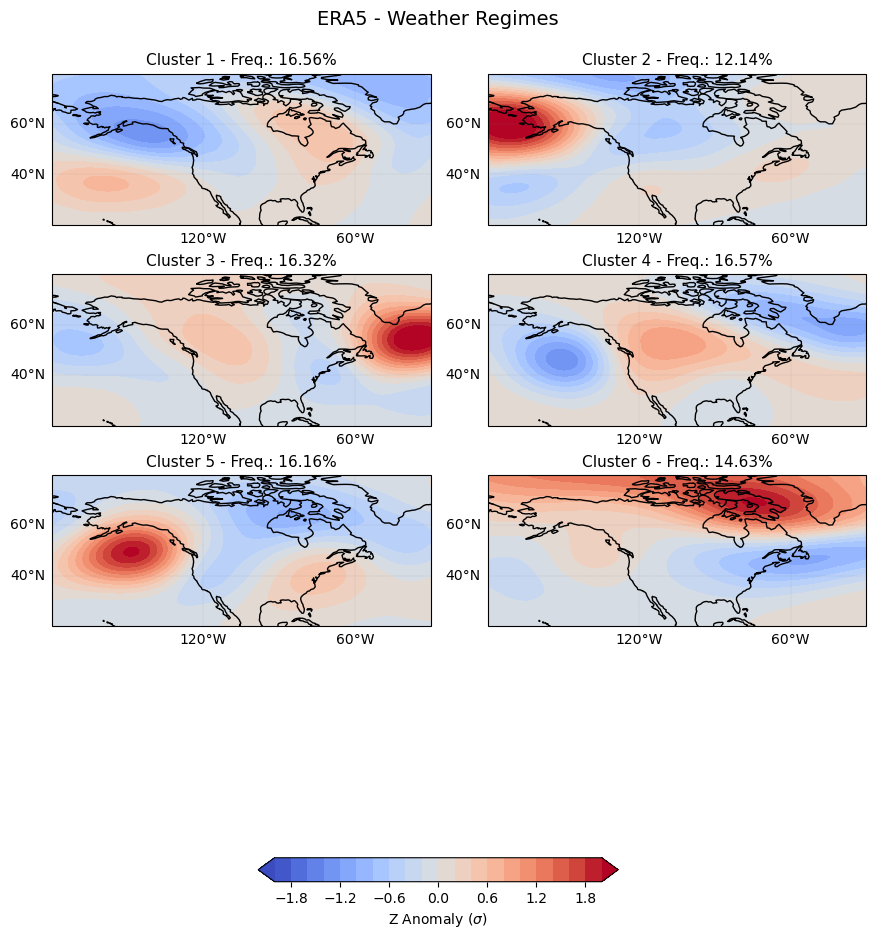

In [54]:
plot_multiple_maps(
    composites,
    frequencies_percent,
    region,
    names=None,
    #path_save=f'Composites_ControlExp_Clean2.png'
)

In [55]:
# composites for subsequent plotting
composites.to_netcdf(
    '/glade/derecho/scratch/molina/WRComps_ERA5_Clean.nc'
)

In [56]:
# dic_results_best_k_ERA5_clean.npy

In [57]:
df_labels.to_csv(
    '/glade/derecho/scratch/molina/WRDF_ERA5_Clean.csv'
)